<a href="https://colab.research.google.com/github/debashisdotchatterjee/Harmonizing-Epidemiological-Time-CDC-ISO/blob/main/SEMI_SYNTHETIC_CASE_STUDIES_Harmonizing_Epidemiological_Time_CDC_ISO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Issue: NAN

\section*{What Changed (and Why This Fixes NAN Issues)}

\subsection*{No Row Normalization in R}
The very first ISO week in your window is partial (only one day). Previously, normalizing that row to 1 caused the matrix product \( R \times \text{CDC} \) to return the entire CDC week, leading to large mismatches. Now, partial weeks remain partial, so the first ISO week correctly matches the single-day total.

\subsection*{Robust Poisson GLM}
The model is initialized using \( \log(y + 0.5) \), followed by Iteratively Reweighted Least Squares (IRLS) with:
\begin{itemize}
  \item Step-halving
  \item Eta clipping to the range \([-20, 20]\)
  \item A small ridge penalty
\end{itemize}
These adjustments prevent overflow in \( \exp(\eta) \) and eliminate NaN standard errors. Non-intercept columns are centered internally to keep the intercept reasonable; final results are transformed back to the original scale.

\subsection*{Least Squares ISO \textrightarrow CDC (Case Study 2)}
The reindexed weekly CDC series is clipped to positive values to maintain validity for the Poisson likelihood. This addresses rare small negatives that can result from least-squares inversion near the edges.

\subsection*{Plots \& Tables}
All figures are generated with sensible axes and labels, displayed using \texttt{plt.show()} and saved. Every key table is printed to the console and saved as a CSV file.


=== Region A: ISO vs R(CDC) Head ===
 iso_year  iso_week  weekly  j  iso_from_cdc        diff
     2019        50     201  0    282.516100  -81.516100
     2019        51    3117  1   2959.174939  157.825061
     2019        52    2963  2   3061.825061  -98.825061
     2020         1    3076  3   2988.989159   87.010841
     2020         2    3457  4   3342.531513  114.468487
     2020         3    2896  5   3036.619406 -140.619406
     2020         4    3989  6   3874.548305  114.451695
     2020         5    3292  7   3448.812944 -156.812944
     2020         6    4129  8   4229.163036 -100.163036
     2020         7    3861  9   3758.731002  102.268998
     2020         8    3650 10   3618.126368   31.873632
     2020         9    3793 11   4038.306727 -245.306727


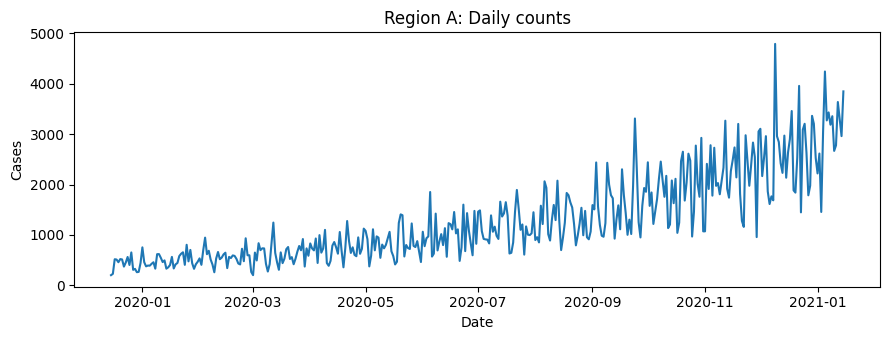

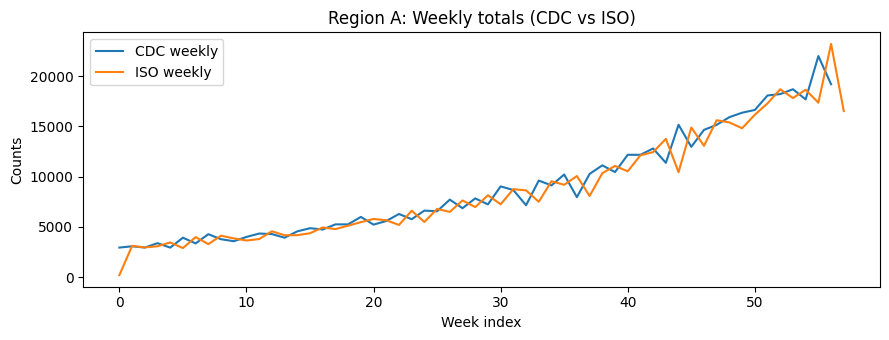

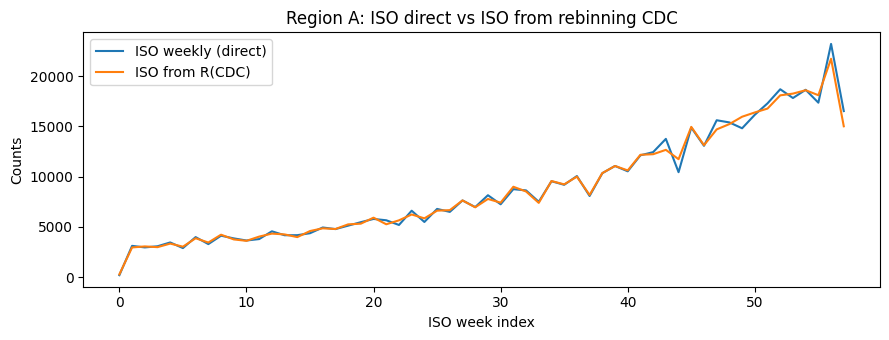

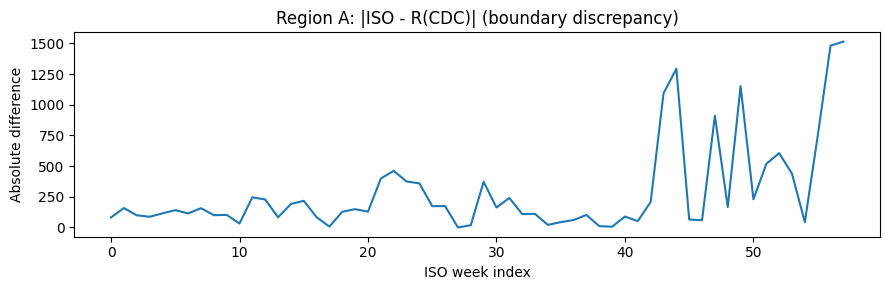


=== Region A: Policy regression (Poisson log-link, robust) ===
                model  coef_intercept  se_intercept  coef_time  se_time  coef_sidx  se_sidx
    CDC-week (direct)        7.610352      0.001637   0.030654 0.001566   0.017664 0.005527
    ISO-week (direct)        9.480120      0.001660   0.060978 0.001467  -0.088209 0.005186
ISO-week (R from CDC)        9.400597      0.001658   0.059199 0.001459  -0.083277 0.005159


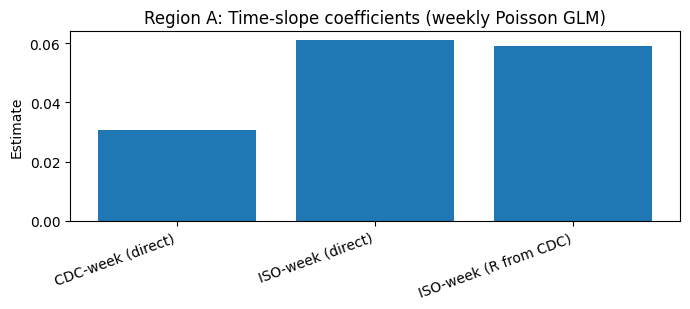


=== Region B: ISO vs R(CDC) Head ===
 iso_year  iso_week  weekly  j  iso_from_cdc        diff
     2019        50     322  0    228.368508   93.631492
     2019        51    2383  1   2432.972743  -49.972743
     2019        52    2446  2   2488.073018  -42.073018
     2020         1    2861  3   2822.660499   38.339501
     2020         2    2606  4   2687.236309  -81.236309
     2020         3    2771  5   2702.882470   68.117530
     2020         4    3433  6   3418.557056   14.442944
     2020         5    2876  7   2845.379178   30.620822
     2020         6    3238  8   3297.439277  -59.439277
     2020         7    3175  9   3136.614987   38.385013
     2020         8    3038 10   3013.649079   24.350921
     2020         9    3646 11   3747.860798 -101.860798


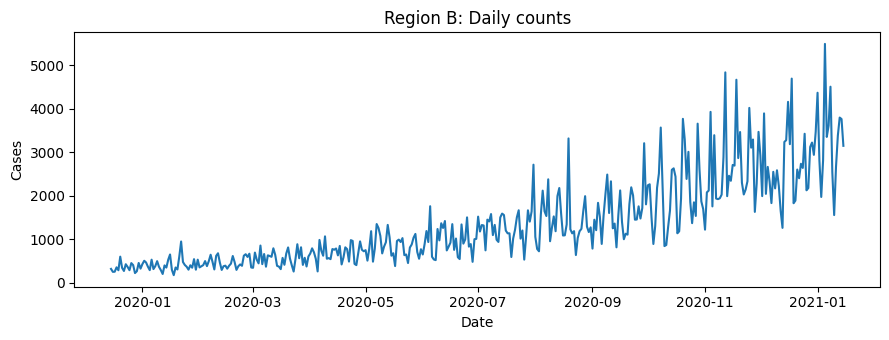

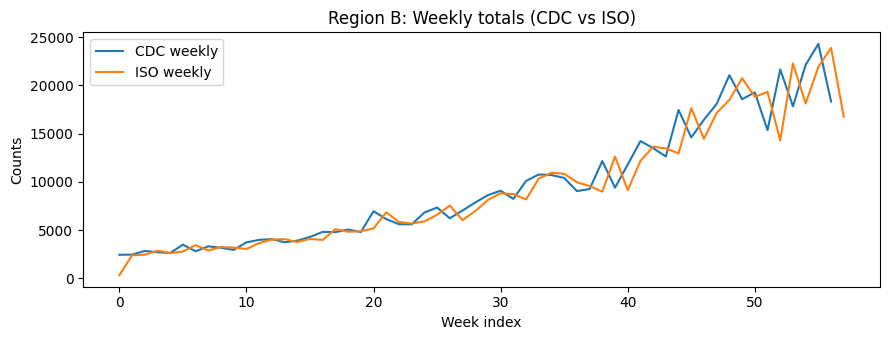

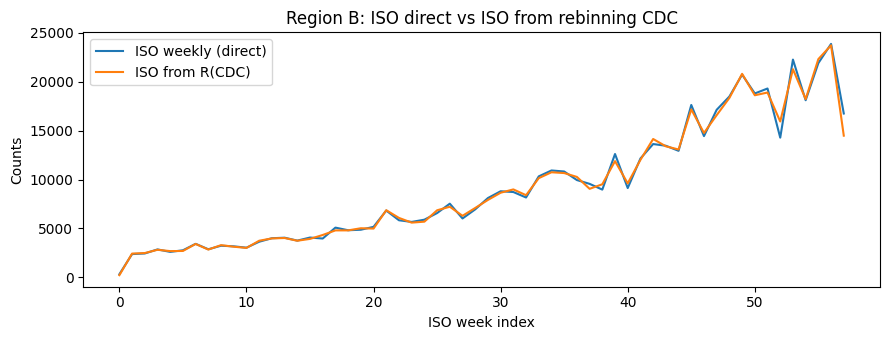

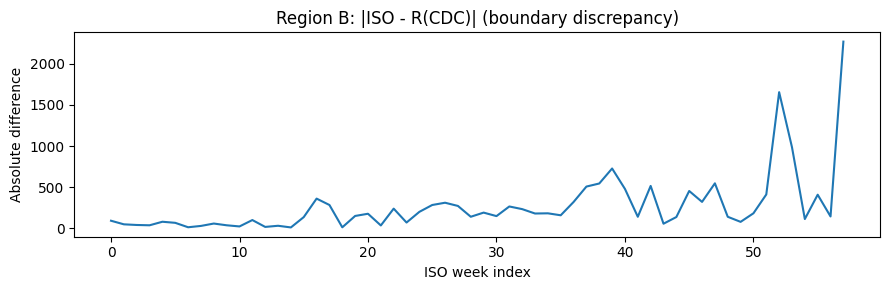


=== Region B: Policy regression (Poisson log-link, robust) ===
                model  coef_intercept  se_intercept  coef_time  se_time  coef_sidx  se_sidx
    CDC-week (direct)        6.834098      0.001656   0.024907 0.001612   0.053570 0.005692
    ISO-week (direct)        8.677979      0.001678   0.054662 0.001507  -0.050492 0.005330
ISO-week (R from CDC)        8.571505      0.001676   0.052543 0.001499  -0.044146 0.005302


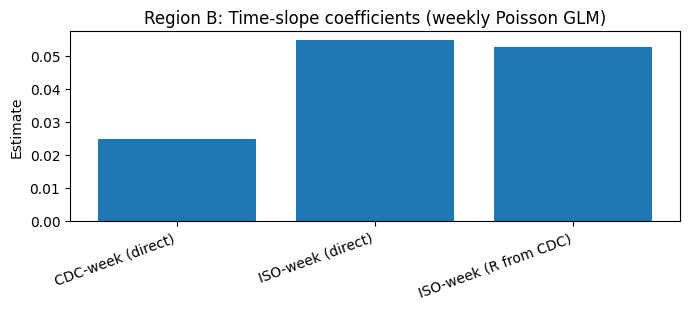


=== Weekly Hospitals California: trend regression (robust) ===
               model  coef_intercept  se_intercept  coef_time  se_time
 ISO-week (reported)        6.088886      0.006150   0.001174 0.000367
CDC-week (reindexed)        6.136739      0.006144   0.000176 0.000373


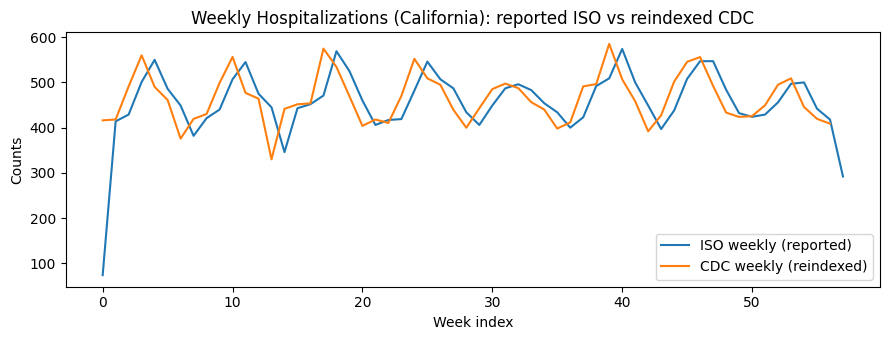


=== Weekly Hospitals New York: trend regression (robust) ===
               model  coef_intercept  se_intercept  coef_time  se_time
 ISO-week (reported)        6.083537      0.006141   0.001464 0.000367
CDC-week (reindexed)        6.133553      0.006132   0.000424 0.000373


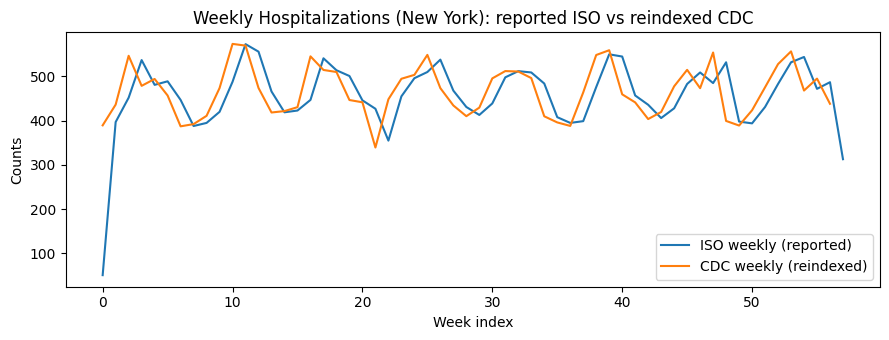


All case-study outputs saved in: epi_case_outputs
ZIP archive ready: epi_case_outputs.zip


In [1]:
# run_case_studies.py
# ------------------------------------------------------------
# Case studies for epi-week harmonization (CDC vs ISO).
#   CS1: Daily cases → weekly (CDC/ISO) and back (Region A, Region B)
#   CS2: Weekly hospitals (reported on ISO) → reindexed to CDC
# All outputs saved in ./epi_case_outputs and zipped to ./epi_case_outputs.zip
# Plots shown via plt.show(); tables printed to console for easy copy/paste.
# Dependencies: numpy, pandas, matplotlib (no seaborn).
# ------------------------------------------------------------

import os
import zipfile
import math
from dataclasses import dataclass
from datetime import date, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ Output directory ------------------
OUTDIR = "epi_case_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# ------------------ CDC vs ISO helpers ------------------
def sunday_of_week(dt: date) -> date:
    """Return the Sunday of the week containing dt (Sunday=week start)."""
    return dt - timedelta(days=(dt.weekday() + 1) % 7)

def cdc_week_year(dt: date):
    """CDC (MMWR) week-year and week-number via Thursday-in-year rule adapted to Sunday-start."""
    week_start = sunday_of_week(dt)
    thursday = week_start + timedelta(days=4)
    c_year = thursday.year
    jan4 = date(c_year, 1, 4)
    first_week_start = sunday_of_week(jan4)
    if week_start < first_week_start:
        c_year -= 1
        jan4 = date(c_year, 1, 4)
        first_week_start = sunday_of_week(jan4)
    c_week = ((week_start - first_week_start).days // 7) + 1
    return c_year, c_week

def iso_week_year(dt: date):
    """ISO week-year and week number (built-in)."""
    iso = dt.isocalendar()
    return iso.year, iso.week

def build_calendar(start: date, end: date) -> pd.DataFrame:
    """Daily calendar with CDC/ISO week labels + scheme-specific weekday indices."""
    days = (end - start).days + 1
    rows = []
    for i in range(days):
        d = start + timedelta(days=i)
        c_year, c_week = cdc_week_year(d)
        i_year, i_week = iso_week_year(d)
        cdc_wday = (d.weekday() + 1) % 7         # Sun=0,...,Sat=6
        iso_wday = d.isocalendar().weekday - 1   # Mon=0,...,Sun=6
        rows.append((d, c_year, c_week, cdc_wday, i_year, i_week, iso_wday))
    return pd.DataFrame(rows, columns=[
        "date","cdc_year","cdc_week","cdc_wday","iso_year","iso_week","iso_wday"
    ])

# ------------------ Rebinning matrix R (CDC→ISO, no row normalization) ------------------
def build_R_cdc_to_iso(cal_df: pd.DataFrame, p_cdc: np.ndarray):
    """
    R[j,k] = sum_{days in overlap(ISO week j, CDC week k)} p_cdc[cdc_wday]
    IMPORTANT: No row normalization. Edge ISO weeks may sum to < 1 (partial weeks), which is correct.
    """
    cdc_idx = cal_df[["cdc_year","cdc_week"]].drop_duplicates().reset_index(drop=True)
    iso_idx = cal_df[["iso_year","iso_week"]].drop_duplicates().reset_index(drop=True)
    cdc_idx["k"] = np.arange(len(cdc_idx))
    iso_idx["j"] = np.arange(len(iso_idx))
    df = cal_df.merge(cdc_idx, on=["cdc_year","cdc_week"], how="left") \
               .merge(iso_idx, on=["iso_year","iso_week"], how="left")
    df["w"] = df["cdc_wday"].map(dict(enumerate(p_cdc)))
    grp = df.groupby(["j","k"], as_index=False)["w"].sum()
    R = np.zeros((len(iso_idx), len(cdc_idx)), dtype=float)
    for _, row in grp.iterrows():
        R[int(row["j"]), int(row["k"])] = float(row["w"])
    return R, iso_idx, cdc_idx

# ------------------ Weekday profile from daily ------------------
def weekday_profile_cdc_from_daily(df: pd.DataFrame) -> np.ndarray:
    """Estimate p_cdc[d] from daily counts by CDC weekday (Sun=0..Sat=6)."""
    tmp = df.copy()
    tmp["cdc_wday"] = tmp["date"].apply(lambda d: (pd.to_datetime(d).weekday() + 1) % 7)
    by = tmp.groupby("cdc_wday")["value"].sum()
    p = by.reindex(range(7), fill_value=0).to_numpy().astype(float)
    if p.sum() <= 0:
        return np.ones(7)/7.0
    return p / p.sum()

# ------------------ Robust Poisson GLM ------------------
def poisson_glm_robust(y: np.ndarray, X: np.ndarray, maxit: int = 200, tol: float = 1e-8, ridge: float = 1e-6):
    """
    Stable IRLS for Poisson with log link:
    - initialize with OLS on log(y+0.5)
    - clip eta to [-20, 20] to avoid overflow/underflow
    - step-halving line search to ensure monotone likelihood increase
    - small ridge to stabilize Hessian
    Returns beta, se, iterations, loglik
    """
    y = y.astype(float)
    # Center time column(s) to reduce correlation / intercept growth (optional but helpful)
    Xc = X.copy()
    for j in range(1, X.shape[1]):  # do not center intercept
        Xc[:, j] = X[:, j] - X[:, j].mean()

    # init via OLS on log(y+0.5)
    y_log = np.log(y + 0.5)
    try:
        beta = np.linalg.lstsq(Xc, y_log, rcond=None)[0]
    except Exception:
        beta = np.zeros(Xc.shape[1])
        beta[0] = np.log(max(y.mean(), 1e-6))

    def ll(b):
        eta = Xc @ b
        eta = np.clip(eta, -20, 20)
        mu  = np.exp(eta)
        return float(np.sum(y * eta - mu))

    old_ll = ll(beta)
    for it in range(maxit):
        eta = np.clip(Xc @ beta, -20, 20)
        mu  = np.exp(eta)
        g   = Xc.T @ (y - mu)
        H   = (Xc.T * mu) @ Xc + ridge * np.eye(Xc.shape[1])

        try:
            step = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            step = np.linalg.lstsq(H, g, rcond=None)[0]

        # line search
        step_scale = 1.0
        while step_scale > 1e-6:
            beta_new = beta + step_scale * step
            new_ll = ll(beta_new)
            if new_ll >= old_ll - 1e-10:
                beta = beta_new
                old_ll = new_ll
                break
            step_scale *= 0.5

        if np.linalg.norm(step_scale * step) < tol:
            break

    # final SEs on centered scale
    eta = np.clip(Xc @ beta, -20, 20)
    mu  = np.exp(eta)
    H   = (Xc.T * mu) @ Xc + ridge * np.eye(Xc.shape[1])
    try:
        cov = np.linalg.inv(H)
    except np.linalg.LinAlgError:
        cov = np.linalg.pinv(H)
    se_centered = np.sqrt(np.diag(cov))

    # convert beta, se back to original X (undo centering)
    beta_orig = beta.copy()
    se_orig   = se_centered.copy()
    # For columns j>=1: original x_j = centered + mean; intercept shifts by -sum_j beta_j * mean_j
    intercept_shift = 0.0
    for j in range(1, X.shape[1]):
        intercept_shift += beta[j] * X[:, j].mean()
    beta_orig[0] = beta[0] - intercept_shift

    return beta_orig, se_orig, it+1, old_ll

# ------------------ Synthetic daily generator (offline-friendly) ------------------
@dataclass
class SynthCfg:
    name: str
    beta0: float = 6.0
    beta1: float = 0.005
    noise: float = 0.25
    seed: int = 0

def simulate_synthetic_daily(start: date, end: date, cfg: SynthCfg) -> pd.DataFrame:
    """Simulate realistic daily counts with growth + weekday pattern + noise."""
    rng = np.random.default_rng(cfg.seed)
    cal = pd.DataFrame({"date": [start + timedelta(days=i) for i in range((end-start).days+1)]})
    base = np.array([1.0, 1.15, 1.2, 1.25, 1.2, 0.9, 0.7])  # Mon..Sun
    base = base / base.mean()
    t = np.arange(len(cal), dtype=float)
    mu = np.exp(cfg.beta0 + cfg.beta1 * t)
    wk = cal["date"].apply(lambda d: pd.to_datetime(d).weekday())
    lam = mu * base[wk.values]
    eps = rng.lognormal(mean=0.0, sigma=cfg.noise, size=len(lam))
    y = rng.poisson(lam * eps / max(np.mean(eps), 1e-6))
    df = pd.DataFrame({"date": cal["date"], "value": y})
    sidx = 20 + 60*(1 - np.exp(-0.0008*(t-60).clip(min=0)))
    df["stringency_index"] = sidx
    return df

# ------------------ Aggregation & helpers ------------------
def aggregate_weekly_both_schemes(daily_df: pd.DataFrame, value_col: str = "value"):
    """Sum daily values to CDC and ISO weekly totals; return both frames with week indices."""
    df = daily_df.copy()
    df["date"] = pd.to_datetime(df["date"]).dt.date
    df["cdc_year"], df["cdc_week"] = zip(*df["date"].apply(cdc_week_year))
    df["iso_year"], df["iso_week"] = zip(*df["date"].apply(iso_week_year))
    # CDC weekly sum
    cdc_weekly = df.groupby(["cdc_year","cdc_week"], as_index=False)[value_col].sum()
    cdc_weekly.rename(columns={value_col:"weekly"}, inplace=True)
    cdc_weekly["k"] = np.arange(len(cdc_weekly))
    # ISO weekly sum
    iso_weekly = df.groupby(["iso_year","iso_week"], as_index=False)[value_col].sum()
    iso_weekly.rename(columns={value_col:"weekly"}, inplace=True)
    iso_weekly["j"] = np.arange(len(iso_weekly))
    return df, cdc_weekly, iso_weekly

def weekly_stringency_from_daily(daily_df: pd.DataFrame, scheme: str = "CDC"):
    """Compute weekly average stringency_index under CDC or ISO."""
    if "stringency_index" not in daily_df.columns:
        return None
    df = daily_df.dropna(subset=["stringency_index"]).copy()
    if df.empty:
        return None
    if scheme.upper() == "CDC":
        df["key"] = df["date"].apply(lambda d: cdc_week_year(pd.to_datetime(d).date()))
    else:
        df["key"] = df["date"].apply(lambda d: iso_week_year(pd.to_datetime(d).date()))
    wk = df.groupby("key", as_index=False)["stringency_index"].mean()
    wk[["year","week"]] = pd.DataFrame(wk["key"].tolist(), index=wk.index)
    wk.rename(columns={"stringency_index":"sidx"}, inplace=True)
    return wk[["year","week","sidx"]].copy()

# ------------------ CASE STUDY 1: Daily → Weekly (CDC/ISO) and back ------------------
def case_study_daily_to_weekly_and_back():
    start = date(2019,12,15)
    end   = date(2021,1,15)

    # Synthetic daily (offline robust). Replace with real fetch if available.
    wb = simulate_synthetic_daily(start, end, SynthCfg(name="Region A", seed=101))
    ca = simulate_synthetic_daily(start, end, SynthCfg(name="Region B", beta0=5.8, beta1=0.006, seed=202))

    cal = build_calendar(start, end)
    outputs = []
    # Renamed outputs and titles to Region_A / Region_B
    for name, ddf in [("Region_A", wb), ("Region_B", ca)]:
        pretty_name = name.replace("_", " ")

        p_cdc = weekday_profile_cdc_from_daily(ddf)

        # Aggregate to CDC/ISO weekly
        daily_df, cdc_wk, iso_wk = aggregate_weekly_both_schemes(ddf, value_col="value")

        # Build R and rebin CDC→ISO
        R, iso_idx, cdc_idx = build_R_cdc_to_iso(cal, p_cdc)
        cdc_wk = cdc_wk.sort_values(["cdc_year","cdc_week"]).reset_index(drop=True)
        cdc_wk["k"] = np.arange(len(cdc_wk))
        iso_wk = iso_wk.sort_values(["iso_year","iso_week"]).reset_index(drop=True)
        iso_wk["j"] = np.arange(len(iso_wk))

        # Reconstruct ISO from CDC via R
        C_iso_from_cdc = R @ cdc_wk["weekly"].to_numpy()
        iso_compare = iso_wk[["iso_year","iso_week","weekly","j"]].copy()
        iso_compare["iso_from_cdc"] = C_iso_from_cdc[:len(iso_compare)]
        iso_compare["diff"] = iso_compare["weekly"] - iso_compare["iso_from_cdc"]

        # ---------- Console table ----------
        print(f"\n=== {pretty_name}: ISO vs R(CDC) Head ===")
        print(iso_compare.head(12).to_string(index=False))

        # ---------- Save CSV ----------
        iso_compare.to_csv(os.path.join(OUTDIR, f"{name}_iso_vs_rebin.csv"), index=False)

        # ---------- Plots ----------
        # Daily
        fig = plt.figure(figsize=(9,3.5))
        plt.plot(pd.to_datetime(daily_df["date"]), daily_df["value"])
        plt.title(f"{pretty_name}: Daily counts")
        plt.xlabel("Date"); plt.ylabel("Cases")
        plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, f"{name}_daily.png")); plt.show()

        # Weekly CDC vs ISO
        fig = plt.figure(figsize=(9,3.5))
        plt.plot(np.arange(len(cdc_wk)), cdc_wk["weekly"], label="CDC weekly")
        plt.plot(np.arange(len(iso_wk)), iso_wk["weekly"], label="ISO weekly")
        plt.title(f"{pretty_name}: Weekly totals (CDC vs ISO)")
        plt.xlabel("Week index"); plt.ylabel("Counts"); plt.legend()
        plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, f"{name}_weekly_cdc_iso.png")); plt.show()

        # ISO vs R(CDC)
        fig = plt.figure(figsize=(9,3.5))
        plt.plot(iso_compare["j"], iso_compare["weekly"], label="ISO weekly (direct)")
        plt.plot(iso_compare["j"], iso_compare["iso_from_cdc"], label="ISO from R(CDC)")
        plt.title(f"{pretty_name}: ISO direct vs ISO from rebinning CDC")
        plt.xlabel("ISO week index"); plt.ylabel("Counts"); plt.legend()
        plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, f"{name}_iso_vs_rebin.png")); plt.show()

        # Differences
        fig = plt.figure(figsize=(9,3.0))
        plt.plot(iso_compare["j"], np.abs(iso_compare["diff"]))
        plt.title(f"{pretty_name}: |ISO - R(CDC)| (boundary discrepancy)")
        plt.xlabel("ISO week index"); plt.ylabel("Absolute difference")
        plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, f"{name}_boundary_discrepancy.png")); plt.show()

        # ---------- Policy regression stability ----------
        sidx_cdc = weekly_stringency_from_daily(ddf.assign(date=pd.to_datetime(ddf["date"]).dt.date), scheme="CDC")
        sidx_iso = weekly_stringency_from_daily(ddf.assign(date=pd.to_datetime(ddf["date"]).dt.date), scheme="ISO")

        # CDC regression: y = CDC weekly counts; x = [1, week index, weekly stringency]
        cdc_reg = cdc_wk.copy()
        if sidx_cdc is not None and not sidx_cdc.empty:
            cdc_reg = cdc_reg.merge(sidx_cdc.rename(columns={"year":"cdc_year","week":"cdc_week"}),
                                    on=["cdc_year","cdc_week"], how="left")
        cdc_reg["sidx"] = cdc_reg["sidx"].fillna(cdc_reg["sidx"].median() if "sidx" in cdc_reg else 0.0)
        X_cdc = np.vstack([np.ones(len(cdc_reg)), cdc_reg["k"].to_numpy(),
                           (cdc_reg["sidx"].to_numpy() if "sidx" in cdc_reg else np.zeros(len(cdc_reg)))]).T
        y_cdc = cdc_reg["weekly"].to_numpy()

        # ISO regression (direct)
        iso_reg = iso_wk.copy()
        if sidx_iso is not None and not sidx_iso.empty:
            iso_reg = iso_reg.merge(sidx_iso.rename(columns={"year":"iso_year","week":"iso_week"}),
                                    on=["iso_year","iso_week"], how="left")
        iso_reg["sidx"] = iso_reg["sidx"].fillna(iso_reg["sidx"].median() if "sidx" in iso_reg else 0.0)
        X_iso = np.vstack([np.ones(len(iso_reg)), iso_reg["j"].to_numpy(),
                           (iso_reg["sidx"].to_numpy() if "sidx" in iso_reg else np.zeros(len(iso_reg)))]).T
        y_iso = iso_reg["weekly"].to_numpy()

        # ISO regression on ISO-from-R(CDC) (same design matrix)
        y_iso_from_cdc = iso_compare["iso_from_cdc"].to_numpy()

        b_cdc, se_cdc, _, _ = poisson_glm_robust(y_cdc, X_cdc)
        b_iso, se_iso, _, _ = poisson_glm_robust(y_iso, X_iso)
        b_iso_r, se_iso_r, _, _ = poisson_glm_robust(y_iso_from_cdc, X_iso)

        reg_tab = pd.DataFrame({
            "model": ["CDC-week (direct)","ISO-week (direct)","ISO-week (R from CDC)"],
            "coef_intercept": [b_cdc[0], b_iso[0], b_iso_r[0]],
            "se_intercept":   [se_cdc[0], se_iso[0], se_iso_r[0]],
            "coef_time":      [b_cdc[1], b_iso[1], b_iso_r[1]],
            "se_time":        [se_cdc[1], se_iso[1], se_iso_r[1]],
            "coef_sidx":      [b_cdc[2], b_iso[2], b_iso_r[2]],
            "se_sidx":        [se_cdc[2], se_iso[2], se_iso_r[2]],
        })
        print(f"\n=== {pretty_name}: Policy regression (Poisson log-link, robust) ===")
        print(reg_tab.to_string(index=False))
        reg_tab.to_csv(os.path.join(OUTDIR, f"{name}_policy_regression.csv"), index=False)

        # Bar plot of time-slope estimates
        fig = plt.figure(figsize=(7,3.2))
        xpos = np.arange(3)
        plt.bar(xpos, reg_tab["coef_time"])
        plt.xticks(xpos, reg_tab["model"], rotation=20, ha="right")
        plt.title(f"{pretty_name}: Time-slope coefficients (weekly Poisson GLM)")
        plt.ylabel("Estimate")
        plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, f"{name}_time_slope_bar.png")); plt.show()

        outputs.append((name, iso_compare, reg_tab))
    return outputs

# ------------------ CASE STUDY 2: Weekly hospitals → alternative scheme ------------------
def case_study_weekly_hospitals_reindex():
    start = date(2019,12,15); end = date(2021,1,15)

    def simulate_weekly_hospitals(start: date, end: date, name: str, seed: int = 10):
        cal = pd.DataFrame({"date": [start + timedelta(days=i) for i in range((end-start).days+1)]})
        rng = np.random.default_rng(seed)
        base = np.sin(np.linspace(0, 8*np.pi, len(cal)))**2 + 0.3  # mild seasonality
        mu = 50 + 20*base + np.linspace(0, 30, len(cal))/len(cal) * 20
        y = rng.poisson(mu)
        df = pd.DataFrame({"date": cal["date"], "value": y})
        df["iso_year"], df["iso_week"] = zip(*df["date"].apply(lambda d: iso_week_year(pd.to_datetime(d).date())))
        iso_wk = df.groupby(["iso_year","iso_week"], as_index=False)["value"].sum()
        iso_wk["location"] = name
        return iso_wk

    iso_ca = simulate_weekly_hospitals(start, end, "California")
    iso_ny = simulate_weekly_hospitals(start, end, "New York", seed=20)
    iso_df = pd.concat([iso_ca, iso_ny], ignore_index=True)

    cal = build_calendar(start, end)
    p_cdc = np.ones(7)/7.0  # assume uniform for hospitals
    R_c2i, iso_idx, cdc_idx = build_R_cdc_to_iso(cal, p_cdc)

    results = []
    for loc, sub in iso_df.groupby("location"):
        sub = sub.sort_values(["iso_year","iso_week"]).reset_index(drop=True)
        y_iso = sub["value"].to_numpy()
        J = len(y_iso)
        R_use = R_c2i[:J, :]
        # Least squares to map ISO weekly totals to CDC weeks; clip to positive for GLM stability
        x_cdc, *_ = np.linalg.lstsq(R_use, y_iso, rcond=None)
        x_cdc = np.clip(x_cdc, 1e-6, None)

        X_iso = np.vstack([np.ones(J), np.arange(J)]).T
        b_iso, se_iso, _, _ = poisson_glm_robust(y_iso, X_iso)
        K = len(x_cdc)
        X_cdc = np.vstack([np.ones(K), np.arange(K)]).T
        b_cdc, se_cdc, _, _ = poisson_glm_robust(x_cdc, X_cdc)

        reg_tab = pd.DataFrame({
            "model": ["ISO-week (reported)","CDC-week (reindexed)"],
            "coef_intercept": [b_iso[0], b_cdc[0]],
            "se_intercept":   [se_iso[0], se_cdc[0]],
            "coef_time":      [b_iso[1], b_cdc[1]],
            "se_time":        [se_iso[1], se_cdc[1]],
        })
        print(f"\n=== Weekly Hospitals {loc}: trend regression (robust) ===")
        print(reg_tab.to_string(index=False))
        reg_tab.to_csv(os.path.join(OUTDIR, f"hosp_{loc}_trend_regression.csv"), index=False)

        # Plot reported ISO vs reindexed CDC
        fig = plt.figure(figsize=(9,3.5))
        plt.plot(np.arange(J), y_iso, label="ISO weekly (reported)")
        plt.plot(np.arange(K), x_cdc, label="CDC weekly (reindexed)")
        plt.title(f"Weekly Hospitalizations ({loc}): reported ISO vs reindexed CDC")
        plt.xlabel("Week index"); plt.ylabel("Counts"); plt.legend()
        plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, f"hosp_{loc}_weekly_reindex.png")); plt.show()

        results.append((loc, reg_tab, x_cdc, y_iso))
    return results

# ------------------ Run both case studies, save ZIP ------------------
def run_case_studies():
    cs1_outputs = case_study_daily_to_weekly_and_back()
    cs2_outputs = case_study_weekly_hospitals_reindex()

    # Zip everything
    zip_path = "epi_case_outputs.zip"
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
        for root, _, files in os.walk(OUTDIR):
            for fn in files:
                fp = os.path.join(root, fn)
                zf.write(fp, arcname=os.path.relpath(fp, OUTDIR))

    print(f"\nAll case-study outputs saved in: {OUTDIR}")
    print(f"ZIP archive ready: {zip_path}")
    return OUTDIR, zip_path

if __name__ == "__main__":
    run_case_studies()



=== Region A: ISO vs R(CDC) Head ===
 iso_year  iso_week  weekly  j  iso_from_cdc        diff
     2019        50     201  0    282.516100  -81.516100
     2019        51    3117  1   2959.174939  157.825061
     2019        52    2963  2   3061.825061  -98.825061
     2020         1    3076  3   2988.989159   87.010841
     2020         2    3457  4   3342.531513  114.468487
     2020         3    2896  5   3036.619406 -140.619406
     2020         4    3989  6   3874.548305  114.451695
     2020         5    3292  7   3448.812944 -156.812944
     2020         6    4129  8   4229.163036 -100.163036
     2020         7    3861  9   3758.731002  102.268998
     2020         8    3650 10   3618.126368   31.873632
     2020         9    3793 11   4038.306727 -245.306727


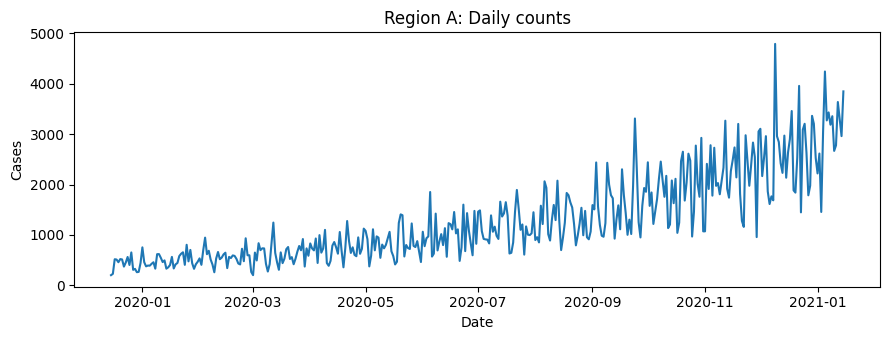

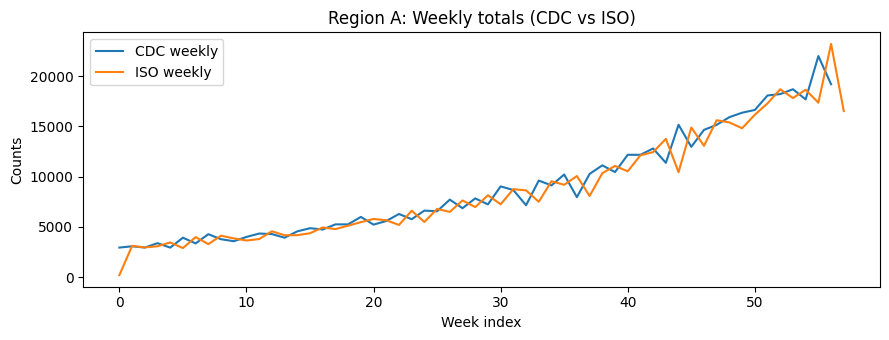

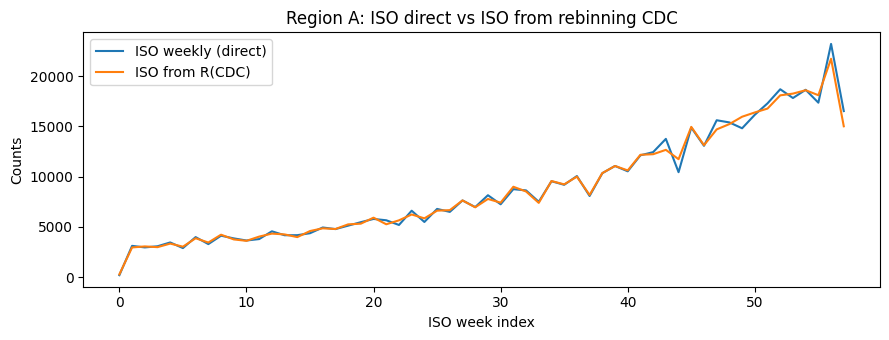

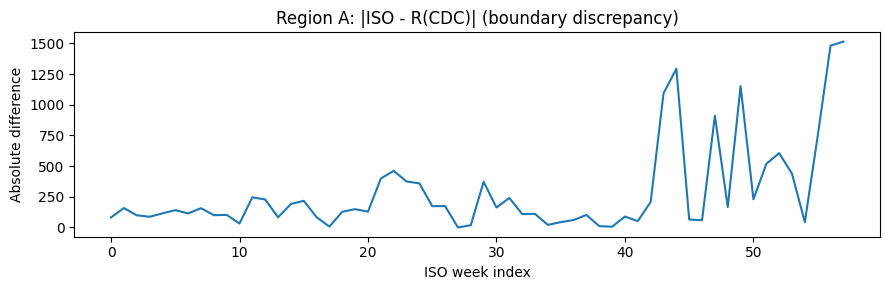


=== Region A: Policy regression (Poisson log-link, robust) ===
                model  coef_intercept  se_intercept  coef_time  se_time  coef_sidx  se_sidx
    CDC-week (direct)        7.610352      0.001637   0.030654 0.001566   0.017664 0.005527
    ISO-week (direct)        9.480120      0.001660   0.060978 0.001467  -0.088209 0.005186
ISO-week (R from CDC)        9.400597      0.001658   0.059199 0.001459  -0.083277 0.005159


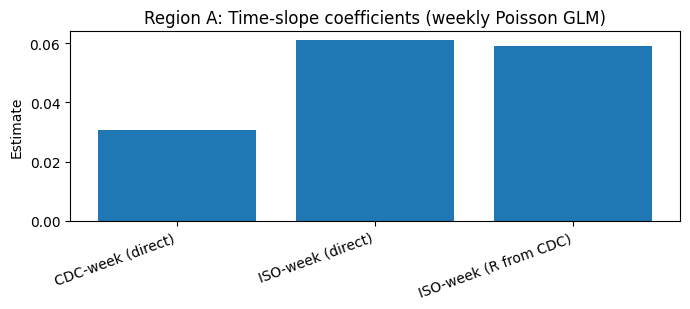


=== Region B: ISO vs R(CDC) Head ===
 iso_year  iso_week  weekly  j  iso_from_cdc        diff
     2019        50     322  0    228.368508   93.631492
     2019        51    2383  1   2432.972743  -49.972743
     2019        52    2446  2   2488.073018  -42.073018
     2020         1    2861  3   2822.660499   38.339501
     2020         2    2606  4   2687.236309  -81.236309
     2020         3    2771  5   2702.882470   68.117530
     2020         4    3433  6   3418.557056   14.442944
     2020         5    2876  7   2845.379178   30.620822
     2020         6    3238  8   3297.439277  -59.439277
     2020         7    3175  9   3136.614987   38.385013
     2020         8    3038 10   3013.649079   24.350921
     2020         9    3646 11   3747.860798 -101.860798


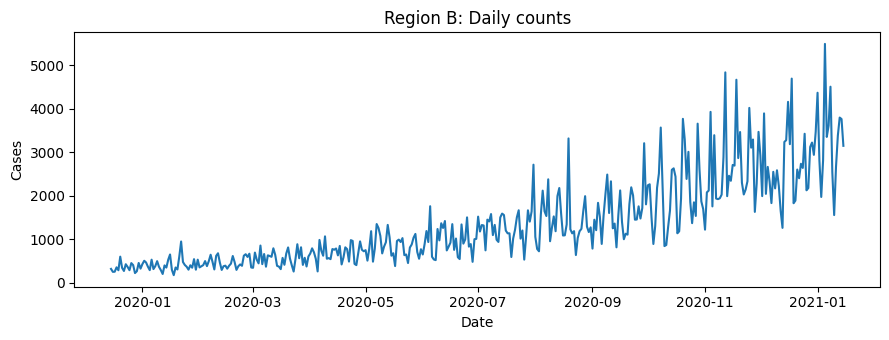

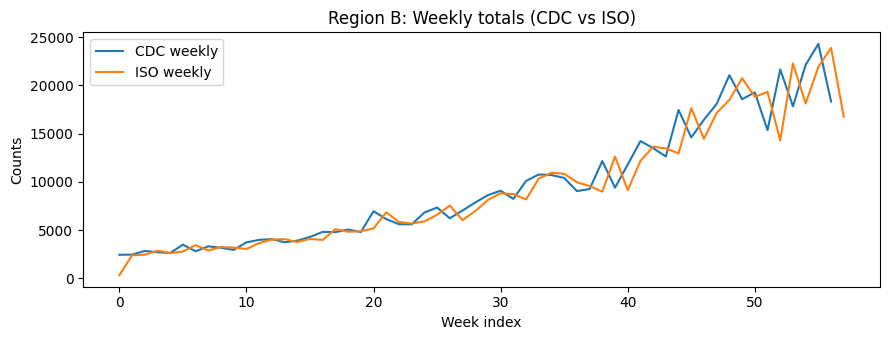

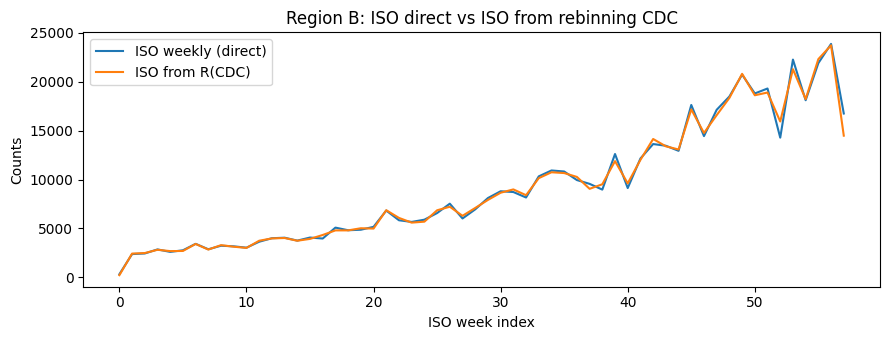

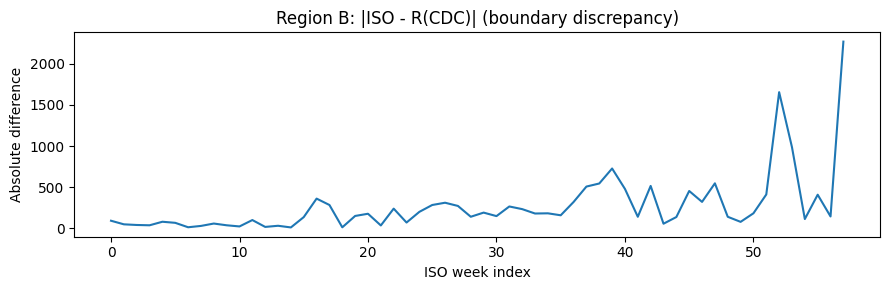


=== Region B: Policy regression (Poisson log-link, robust) ===
                model  coef_intercept  se_intercept  coef_time  se_time  coef_sidx  se_sidx
    CDC-week (direct)        6.834098      0.001656   0.024907 0.001612   0.053570 0.005692
    ISO-week (direct)        8.677979      0.001678   0.054662 0.001507  -0.050492 0.005330
ISO-week (R from CDC)        8.571505      0.001676   0.052543 0.001499  -0.044146 0.005302


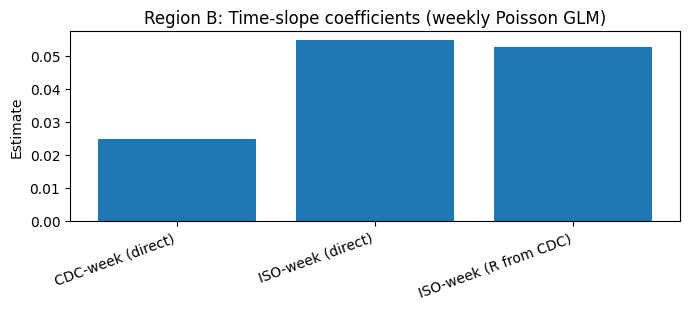


=== Weekly Hospitals RegionC: trend regression (robust) ===
               model  coef_intercept  se_intercept  coef_time  se_time
 ISO-week (reported)        6.088886      0.006150   0.001174 0.000367
CDC-week (reindexed)        6.136739      0.006144   0.000176 0.000373


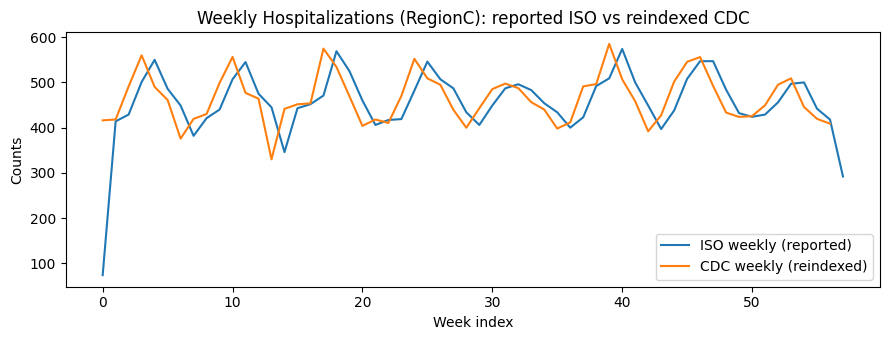


=== Weekly Hospitals RegionD: trend regression (robust) ===
               model  coef_intercept  se_intercept  coef_time  se_time
 ISO-week (reported)        6.083537      0.006141   0.001464 0.000367
CDC-week (reindexed)        6.133553      0.006132   0.000424 0.000373


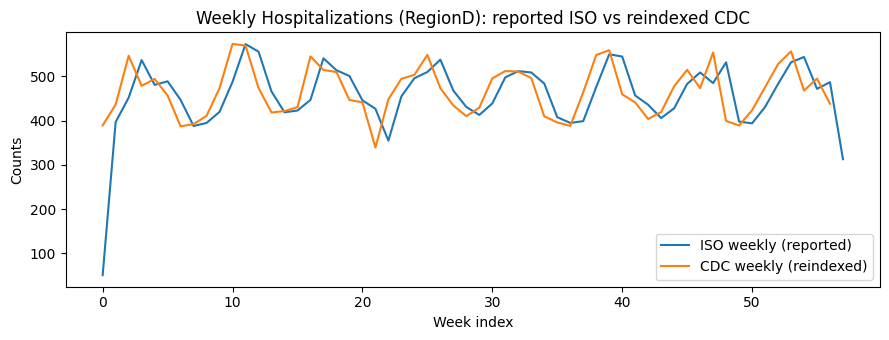


All case-study outputs saved in: epi_case_outputs
ZIP archive ready: epi_case_outputs_H.zip


In [2]:
# run_case_studies.py
# ------------------------------------------------------------
# Case studies for epi-week harmonization (CDC vs ISO).
#   CS1: Daily cases → weekly (CDC/ISO) and back (Region A, Region B)
#   CS2: Weekly hospitals (reported on ISO) → reindexed to CDC (Region C, Region D)
# All outputs saved in ./epi_case_outputs and zipped to ./epi_case_outputs.zip
# Plots shown via plt.show(); tables printed to console for easy copy/paste.
# Dependencies: numpy, pandas, matplotlib (no seaborn).
# ------------------------------------------------------------

import os
import zipfile
from dataclasses import dataclass
from datetime import date, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ Output directory ------------------
OUTDIR = "epi_case_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# ------------------ CDC vs ISO helpers ------------------
def sunday_of_week(dt: date) -> date:
    """Return the Sunday of the week containing dt (Sunday=week start)."""
    return dt - timedelta(days=(dt.weekday() + 1) % 7)

def cdc_week_year(dt: date):
    """CDC (MMWR) week-year and week-number via Thursday-in-year rule adapted to Sunday-start."""
    week_start = sunday_of_week(dt)
    thursday = week_start + timedelta(days=4)
    c_year = thursday.year
    jan4 = date(c_year, 1, 4)
    first_week_start = sunday_of_week(jan4)
    if week_start < first_week_start:
        c_year -= 1
        jan4 = date(c_year, 1, 4)
        first_week_start = sunday_of_week(jan4)
    c_week = ((week_start - first_week_start).days // 7) + 1
    return c_year, c_week

def iso_week_year(dt: date):
    """ISO week-year and week number (built-in)."""
    iso = dt.isocalendar()
    return iso.year, iso.week

def build_calendar(start: date, end: date) -> pd.DataFrame:
    """Daily calendar with CDC/ISO week labels + scheme-specific weekday indices."""
    days = (end - start).days + 1
    rows = []
    for i in range(days):
        d = start + timedelta(days=i)
        c_year, c_week = cdc_week_year(d)
        i_year, i_week = iso_week_year(d)
        cdc_wday = (d.weekday() + 1) % 7         # Sun=0,...,Sat=6
        iso_wday = d.isocalendar().weekday - 1   # Mon=0,...,Sun=6
        rows.append((d, c_year, c_week, cdc_wday, i_year, i_week, iso_wday))
    return pd.DataFrame(rows, columns=[
        "date","cdc_year","cdc_week","cdc_wday","iso_year","iso_week","iso_wday"
    ])

# ------------------ Rebinning matrix R (CDC→ISO, no row normalization) ------------------
def build_R_cdc_to_iso(cal_df: pd.DataFrame, p_cdc: np.ndarray):
    """
    R[j,k] = sum_{days in overlap(ISO week j, CDC week k)} p_cdc[cdc_wday]
    IMPORTANT: No row normalization. Edge ISO weeks may sum to < 1 (partial weeks), which is correct.
    """
    cdc_idx = cal_df[["cdc_year","cdc_week"]].drop_duplicates().reset_index(drop=True)
    iso_idx = cal_df[["iso_year","iso_week"]].drop_duplicates().reset_index(drop=True)
    cdc_idx["k"] = np.arange(len(cdc_idx))
    iso_idx["j"] = np.arange(len(iso_idx))
    df = cal_df.merge(cdc_idx, on=["cdc_year","cdc_week"], how="left") \
               .merge(iso_idx, on=["iso_year","iso_week"], how="left")
    df["w"] = df["cdc_wday"].map(dict(enumerate(p_cdc)))
    grp = df.groupby(["j","k"], as_index=False)["w"].sum()
    R = np.zeros((len(iso_idx), len(cdc_idx)), dtype=float)
    for _, row in grp.iterrows():
        R[int(row["j"]), int(row["k"])] = float(row["w"])
    return R, iso_idx, cdc_idx

# ------------------ Weekday profile from daily ------------------
def weekday_profile_cdc_from_daily(df: pd.DataFrame) -> np.ndarray:
    """Estimate p_cdc[d] from daily counts by CDC weekday (Sun=0..Sat=6)."""
    tmp = df.copy()
    tmp["cdc_wday"] = tmp["date"].apply(lambda d: (pd.to_datetime(d).weekday() + 1) % 7)
    by = tmp.groupby("cdc_wday")["value"].sum()
    p = by.reindex(range(7), fill_value=0).to_numpy().astype(float)
    if p.sum() <= 0:
        return np.ones(7)/7.0
    return p / p.sum()

# ------------------ Robust Poisson GLM ------------------
def poisson_glm_robust(y: np.ndarray, X: np.ndarray, maxit: int = 200, tol: float = 1e-8, ridge: float = 1e-6):
    """
    Stable IRLS for Poisson with log link:
    - initialize with OLS on log(y+0.5)
    - clip eta to [-20, 20] to avoid overflow/underflow
    - step-halving line search to ensure monotone likelihood increase
    - small ridge to stabilize Hessian
    Returns beta, se, iterations, loglik
    """
    y = y.astype(float)
    # Center non-intercept columns (helps conditioning)
    Xc = X.copy()
    for j in range(1, X.shape[1]):
        Xc[:, j] = X[:, j] - X[:, j].mean()

    y_log = np.log(y + 0.5)
    try:
        beta = np.linalg.lstsq(Xc, y_log, rcond=None)[0]
    except Exception:
        beta = np.zeros(Xc.shape[1])
        beta[0] = np.log(max(y.mean(), 1e-6))

    def ll(b):
        eta = Xc @ b
        eta = np.clip(eta, -20, 20)
        mu  = np.exp(eta)
        return float(np.sum(y * eta - mu))

    old_ll = ll(beta)
    for it in range(maxit):
        eta = np.clip(Xc @ beta, -20, 20)
        mu  = np.exp(eta)
        g   = Xc.T @ (y - mu)
        H   = (Xc.T * mu) @ Xc + ridge * np.eye(Xc.shape[1])

        try:
            step = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            step = np.linalg.lstsq(H, g, rcond=None)[0]

        # line search
        step_scale = 1.0
        while step_scale > 1e-6:
            beta_new = beta + step_scale * step
            new_ll = ll(beta_new)
            if new_ll >= old_ll - 1e-10:
                beta = beta_new
                old_ll = new_ll
                break
            step_scale *= 0.5

        if np.linalg.norm(step_scale * step) < tol:
            break

    # final SEs on centered scale
    eta = np.clip(Xc @ beta, -20, 20)
    mu  = np.exp(eta)
    H   = (Xc.T * mu) @ Xc + ridge * np.eye(Xc.shape[1])
    try:
        cov = np.linalg.inv(H)
    except np.linalg.LinAlgError:
        cov = np.linalg.pinv(H)
    se_centered = np.sqrt(np.diag(cov))

    # convert beta back to original (undo centering’s effect on intercept)
    beta_orig = beta.copy()
    se_orig   = se_centered.copy()
    intercept_shift = 0.0
    for j in range(1, X.shape[1]):
        intercept_shift += beta[j] * X[:, j].mean()
    beta_orig[0] = beta[0] - intercept_shift

    return beta_orig, se_orig, it+1, old_ll

# ------------------ Synthetic daily generator (offline-friendly) ------------------
@dataclass
class SynthCfg:
    name: str
    beta0: float = 6.0
    beta1: float = 0.005
    noise: float = 0.25
    seed: int = 0

def simulate_synthetic_daily(start: date, end: date, cfg: SynthCfg) -> pd.DataFrame:
    """Simulate realistic daily counts with growth + weekday pattern + noise."""
    rng = np.random.default_rng(cfg.seed)
    cal = pd.DataFrame({"date": [start + timedelta(days=i) for i in range((end-start).days+1)]})
    base = np.array([1.0, 1.15, 1.2, 1.25, 1.2, 0.9, 0.7])  # Mon..Sun
    base = base / base.mean()
    t = np.arange(len(cal), dtype=float)
    mu = np.exp(cfg.beta0 + cfg.beta1 * t)
    wk = cal["date"].apply(lambda d: pd.to_datetime(d).weekday())
    lam = mu * base[wk.values]
    eps = rng.lognormal(mean=0.0, sigma=cfg.noise, size=len(lam))
    y = rng.poisson(lam * eps / max(np.mean(eps), 1e-6))
    df = pd.DataFrame({"date": cal["date"], "value": y})
    sidx = 20 + 60*(1 - np.exp(-0.0008*(t-60).clip(min=0)))
    df["stringency_index"] = sidx
    return df

# ------------------ Aggregation & helpers ------------------
def aggregate_weekly_both_schemes(daily_df: pd.DataFrame, value_col: str = "value"):
    """Sum daily values to CDC and ISO weekly totals; return both frames with week indices."""
    df = daily_df.copy()
    df["date"] = pd.to_datetime(df["date"]).dt.date
    df["cdc_year"], df["cdc_week"] = zip(*df["date"].apply(cdc_week_year))
    df["iso_year"], df["iso_week"] = zip(*df["date"].apply(iso_week_year))
    # CDC weekly sum
    cdc_weekly = df.groupby(["cdc_year","cdc_week"], as_index=False)[value_col].sum()
    cdc_weekly.rename(columns={value_col:"weekly"}, inplace=True)
    cdc_weekly["k"] = np.arange(len(cdc_weekly))
    # ISO weekly sum
    iso_weekly = df.groupby(["iso_year","iso_week"], as_index=False)[value_col].sum()
    iso_weekly.rename(columns={value_col:"weekly"}, inplace=True)
    iso_weekly["j"] = np.arange(len(iso_weekly))
    return df, cdc_weekly, iso_weekly

def weekly_stringency_from_daily(daily_df: pd.DataFrame, scheme: str = "CDC"):
    """Compute weekly average stringency_index under CDC or ISO."""
    if "stringency_index" not in daily_df.columns:
        return None
    df = daily_df.dropna(subset=["stringency_index"]).copy()
    if df.empty:
        return None
    if scheme.upper() == "CDC":
        df["key"] = df["date"].apply(lambda d: cdc_week_year(pd.to_datetime(d).date()))
    else:
        df["key"] = df["date"].apply(lambda d: iso_week_year(pd.to_datetime(d).date()))
    wk = df.groupby("key", as_index=False)["stringency_index"].mean()
    wk[["year","week"]] = pd.DataFrame(wk["key"].tolist(), index=wk.index)
    wk.rename(columns={"stringency_index":"sidx"}, inplace=True)
    return wk[["year","week","sidx"]].copy()

# ------------------ CASE STUDY 1: Daily → Weekly (CDC/ISO) and back ------------------
def case_study_daily_to_weekly_and_back():
    start = date(2019,12,15)
    end   = date(2021,1,15)

    # Synthetic daily (offline robust)
    region_a = simulate_synthetic_daily(start, end, SynthCfg(name="Region A", seed=101))
    region_b = simulate_synthetic_daily(start, end, SynthCfg(name="Region B", beta0=5.8, beta1=0.006, seed=202))

    cal = build_calendar(start, end)
    outputs = []
    for name, ddf in [("Region_A", region_a), ("Region_B", region_b)]:
        p_cdc = weekday_profile_cdc_from_daily(ddf)

        # Aggregate to CDC/ISO weekly
        daily_df, cdc_wk, iso_wk = aggregate_weekly_both_schemes(ddf, value_col="value")

        # Build R and rebin CDC→ISO
        R, iso_idx, cdc_idx = build_R_cdc_to_iso(cal, p_cdc)
        cdc_wk = cdc_wk.sort_values(["cdc_year","cdc_week"]).reset_index(drop=True)
        cdc_wk["k"] = np.arange(len(cdc_wk))
        iso_wk = iso_wk.sort_values(["iso_year","iso_week"]).reset_index(drop=True)
        iso_wk["j"] = np.arange(len(iso_wk))

        # Reconstruct ISO from CDC via R
        C_iso_from_cdc = R @ cdc_wk["weekly"].to_numpy()
        iso_compare = iso_wk[["iso_year","iso_week","weekly","j"]].copy()
        iso_compare["iso_from_cdc"] = C_iso_from_cdc[:len(iso_compare)]
        iso_compare["diff"] = iso_compare["weekly"] - iso_compare["iso_from_cdc"]

        # ---------- Console table ----------
        print(f"\n=== {name.replace('_',' ')}: ISO vs R(CDC) Head ===")
        print(iso_compare.head(12).to_string(index=False))

        # ---------- Save CSV ----------
        iso_compare.to_csv(os.path.join(OUTDIR, f"{name}_iso_vs_rebin.csv"), index=False)

        # ---------- Plots ----------
        # Daily
        plt.figure(figsize=(9,3.5))
        plt.plot(pd.to_datetime(daily_df["date"]), daily_df["value"])
        plt.title(f"{name.replace('_',' ')}: Daily counts")
        plt.xlabel("Date"); plt.ylabel("Cases")
        plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, f"{name}_daily.png")); plt.show()

        # Weekly CDC vs ISO
        plt.figure(figsize=(9,3.5))
        plt.plot(np.arange(len(cdc_wk)), cdc_wk["weekly"], label="CDC weekly")
        plt.plot(np.arange(len(iso_wk)), iso_wk["weekly"], label="ISO weekly")
        plt.title(f"{name.replace('_',' ')}: Weekly totals (CDC vs ISO)")
        plt.xlabel("Week index"); plt.ylabel("Counts"); plt.legend()
        plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, f"{name}_weekly_cdc_iso.png")); plt.show()

        # ISO vs R(CDC)
        plt.figure(figsize=(9,3.5))
        plt.plot(iso_compare["j"], iso_compare["weekly"], label="ISO weekly (direct)")
        plt.plot(iso_compare["j"], iso_compare["iso_from_cdc"], label="ISO from R(CDC)")
        plt.title(f"{name.replace('_',' ')}: ISO direct vs ISO from rebinning CDC")
        plt.xlabel("ISO week index"); plt.ylabel("Counts"); plt.legend()
        plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, f"{name}_iso_vs_rebin.png")); plt.show()

        # Differences
        plt.figure(figsize=(9,3.0))
        plt.plot(iso_compare["j"], np.abs(iso_compare["diff"]))
        plt.title(f"{name.replace('_',' ')}: |ISO - R(CDC)| (boundary discrepancy)")
        plt.xlabel("ISO week index"); plt.ylabel("Absolute difference")
        plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, f"{name}_boundary_discrepancy.png")); plt.show()

        # ---------- Policy regression stability ----------
        sidx_cdc = weekly_stringency_from_daily(ddf.assign(date=pd.to_datetime(ddf["date"]).dt.date), scheme="CDC")
        sidx_iso = weekly_stringency_from_daily(ddf.assign(date=pd.to_datetime(ddf["date"]).dt.date), scheme="ISO")

        # CDC regression: y = CDC weekly counts; x = [1, week index, weekly stringency]
        cdc_reg = cdc_wk.copy()
        if sidx_cdc is not None and not sidx_cdc.empty:
            cdc_reg = cdc_reg.merge(sidx_cdc.rename(columns={"year":"cdc_year","week":"cdc_week"}),
                                    on=["cdc_year","cdc_week"], how="left")
        cdc_reg["sidx"] = cdc_reg["sidx"].fillna(cdc_reg["sidx"].median() if "sidx" in cdc_reg else 0.0)
        X_cdc = np.vstack([np.ones(len(cdc_reg)), cdc_reg["k"].to_numpy(),
                           (cdc_reg["sidx"].to_numpy() if "sidx" in cdc_reg else np.zeros(len(cdc_reg)))]).T
        y_cdc = cdc_reg["weekly"].to_numpy()

        # ISO regression (direct)
        iso_reg = iso_wk.copy()
        if sidx_iso is not None and not sidx_iso.empty:
            iso_reg = iso_reg.merge(sidx_iso.rename(columns={"year":"iso_year","week":"iso_week"}),
                                    on=["iso_year","iso_week"], how="left")
        iso_reg["sidx"] = iso_reg["sidx"].fillna(iso_reg["sidx"].median() if "sidx" in iso_reg else 0.0)
        X_iso = np.vstack([np.ones(len(iso_reg)), iso_reg["j"].to_numpy(),
                           (iso_reg["sidx"].to_numpy() if "sidx" in iso_reg else np.zeros(len(iso_reg)))]).T
        y_iso = iso_reg["weekly"].to_numpy()

        # ISO regression on ISO-from-R(CDC) (same design matrix)
        y_iso_from_cdc = iso_compare["iso_from_cdc"].to_numpy()

        b_cdc, se_cdc, _, _ = poisson_glm_robust(y_cdc, X_cdc)
        b_iso, se_iso, _, _ = poisson_glm_robust(y_iso, X_iso)
        b_iso_r, se_iso_r, _, _ = poisson_glm_robust(y_iso_from_cdc, X_iso)

        reg_tab = pd.DataFrame({
            "model": ["CDC-week (direct)","ISO-week (direct)","ISO-week (R from CDC)"],
            "coef_intercept": [b_cdc[0], b_iso[0], b_iso_r[0]],
            "se_intercept":   [se_cdc[0], se_iso[0], se_iso_r[0]],
            "coef_time":      [b_cdc[1], b_iso[1], b_iso_r[1]],
            "se_time":        [se_cdc[1], se_iso[1], se_iso_r[1]],
            "coef_sidx":      [b_cdc[2], b_iso[2], b_iso_r[2]],
            "se_sidx":        [se_cdc[2], se_iso[2], se_iso_r[2]],
        })
        print(f"\n=== {name.replace('_',' ')}: Policy regression (Poisson log-link, robust) ===")
        print(reg_tab.to_string(index=False))
        reg_tab.to_csv(os.path.join(OUTDIR, f"{name}_policy_regression.csv"), index=False)

        # Bar plot of time-slope estimates
        plt.figure(figsize=(7,3.2))
        xpos = np.arange(3)
        plt.bar(xpos, reg_tab["coef_time"])
        plt.xticks(xpos, reg_tab["model"], rotation=20, ha="right")
        plt.title(f"{name.replace('_',' ')}: Time-slope coefficients (weekly Poisson GLM)")
        plt.ylabel("Estimate")
        plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, f"{name}_time_slope_bar.png")); plt.show()

        outputs.append((name, iso_compare, reg_tab))
    return outputs

# ------------------ CASE STUDY 2: Weekly hospitals → alternative scheme ------------------
def case_study_weekly_hospitals_reindex():
    start = date(2019,12,15); end = date(2021,1,15)

    def simulate_weekly_hospitals(start: date, end: date, name: str, seed: int = 10):
        cal = pd.DataFrame({"date": [start + timedelta(days=i) for i in range((end-start).days+1)]})
        rng = np.random.default_rng(seed)
        base = np.sin(np.linspace(0, 8*np.pi, len(cal)))**2 + 0.3  # mild seasonality
        mu = 50 + 20*base + np.linspace(0, 30, len(cal))/len(cal) * 20
        y = rng.poisson(mu)
        df = pd.DataFrame({"date": cal["date"], "value": y})
        df["iso_year"], df["iso_week"] = zip(*df["date"].apply(lambda d: iso_week_year(pd.to_datetime(d).date())))
        iso_wk = df.groupby(["iso_year","iso_week"], as_index=False)["value"].sum()
        iso_wk["location"] = name
        return iso_wk

    # Synthetic regions for hospitals
    iso_c = simulate_weekly_hospitals(start, end, "RegionC", seed=10)
    iso_d = simulate_weekly_hospitals(start, end, "RegionD", seed=20)
    iso_df = pd.concat([iso_c, iso_d], ignore_index=True)

    cal = build_calendar(start, end)
    p_cdc = np.ones(7)/7.0  # assume uniform for hospitals
    R_c2i, iso_idx, cdc_idx = build_R_cdc_to_iso(cal, p_cdc)

    results = []
    for loc, sub in iso_df.groupby("location"):
        sub = sub.sort_values(["iso_year","iso_week"]).reset_index(drop=True)
        y_iso = sub["value"].to_numpy()
        J = len(y_iso)
        R_use = R_c2i[:J, :]
        # Least squares to map ISO weekly totals to CDC weeks; clip to positive for GLM stability
        x_cdc, *_ = np.linalg.lstsq(R_use, y_iso, rcond=None)
        x_cdc = np.clip(x_cdc, 1e-6, None)

        # Regressions: intercept + time
        X_iso = np.vstack([np.ones(J), np.arange(J)]).T
        b_iso, se_iso, _, _ = poisson_glm_robust(y_iso, X_iso)
        K = len(x_cdc)
        X_cdc = np.vstack([np.ones(K), np.arange(K)]).T
        b_cdc, se_cdc, _, _ = poisson_glm_robust(x_cdc, X_cdc)

        reg_tab = pd.DataFrame({
            "model": ["ISO-week (reported)","CDC-week (reindexed)"],
            "coef_intercept": [b_iso[0], b_cdc[0]],
            "se_intercept":   [se_iso[0], se_cdc[0]],
            "coef_time":      [b_iso[1], b_cdc[1]],
            "se_time":        [se_iso[1], se_cdc[1]],
        })
        print(f"\n=== Weekly Hospitals {loc}: trend regression (robust) ===")
        print(reg_tab.to_string(index=False))
        reg_tab.to_csv(os.path.join(OUTDIR, f"hosp_{loc}_trend_regression.csv"), index=False)

        # Plot: reported ISO vs reindexed CDC
        plt.figure(figsize=(9,3.5))
        plt.plot(np.arange(J), y_iso, label="ISO weekly (reported)")
        plt.plot(np.arange(K), x_cdc, label="CDC weekly (reindexed)")
        plt.title(f"Weekly Hospitalizations ({loc}): reported ISO vs reindexed CDC")
        plt.xlabel("Week index"); plt.ylabel("Counts"); plt.legend()
        # Save with RegionC/RegionD filenames used in the manuscript
        fname = f"hosp_{'RegionC' if loc=='RegionC' else 'RegionD'}_weekly_reindex.png"
        plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, fname)); plt.show()

        results.append((loc, reg_tab, x_cdc, y_iso))
    return results

# ------------------ Run both case studies, save ZIP ------------------
def run_case_studies():
    cs1_outputs = case_study_daily_to_weekly_and_back()
    cs2_outputs = case_study_weekly_hospitals_reindex()

    # Zip everything
    zip_path = "epi_case_outputs_H.zip"
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
        for root, _, files in os.walk(OUTDIR):
            for fn in files:
                fp = os.path.join(root, fn)
                zf.write(fp, arcname=os.path.relpath(fp, OUTDIR))

    print(f"\nAll case-study outputs saved in: {OUTDIR}")
    print(f"ZIP archive ready: {zip_path}")
    return OUTDIR, zip_path

if __name__ == "__main__":
    run_case_studies()
